# Model 3: using mixed data (satellite imagery and structured data) to predict where traffic accidents will happen

Additional data used to get the LSOA for each latitude and longitude point, in order to match with the population data.

Source: https://data.london.gov.uk/dataset/mylondon

## Obtaining and preparing the data

### Importing the data

In [149]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
from scipy.spatial import cKDTree
np.random.seed(123)
from shapely.ops import nearest_points
import geopandas
from math import *
import urllib, os
import matplotlib.pyplot as plt
%matplotlib inline

In [204]:
accidents = pd.read_csv('data/modelling/London_accidents_merged.csv')
accidents.head()

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Hour,Two_Hour_Groupings,Time_of_Day,Was_Daylight,Was_Bad_Weather,Was_Road_Dry,log_Number_of_Casualties,log_Number_of_Vehicles,LSOA,population_per_hectare,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf,Road,RCat
0,201301BS70003,-0.171402,51.486361,Serious,2,1,2013-01-02,Wednesday,A,Single carriageway,30.0,T or staggered junction,Unclassified,Daylight,Fine no high winds,Dry,Urban,9,8am-10am,Morning,Yes,No,Yes,0.000000,0.693147,E01002844,110.8,1634.4,860.4,14888.0,1139.8,2297.0,352.0,A3217,PA
1,201301BS70005,-0.173356,51.495115,Slight,1,2,2013-01-04,Friday,A,Single carriageway,30.0,Crossroads,A,Daylight,Other,Dry,Urban,8,8am-10am,Morning,Yes,Yes,Yes,0.693147,0.000000,E01002821,74.6,559.6,1516.0,28505.6,1396.2,3868.6,1003.0,A4,PA
2,201301BS70006,-0.210767,51.518353,Slight,1,1,2013-01-07,Monday,B,Single carriageway,30.0,Crossroads,B,Daylight,Fine no high winds,Dry,Urban,11,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.000000,E01002878,133.4,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
3,201301BS70007,-0.209675,51.516808,Slight,2,1,2013-01-10,Thursday,B,Single carriageway,30.0,Crossroads,C,Daylight,Fine no high winds,Dry,Urban,10,10am-12pm,Office hours,Yes,No,Yes,0.000000,0.693147,E01002831,179.2,2.6,3898.2,63274.8,763.4,15253.6,3185.8,A40,PA
4,201301BS70009,-0.194332,51.492922,Slight,2,1,2013-01-04,Friday,A,One way street,30.0,T or staggered junction,Unclassified,Darkness - lights lit,Fine no high winds,Dry,Urban,17,4pm-6pm,Rush hour,No,No,Yes,0.000000,0.693147,E01002851,272.3,869.2,1229.8,20478.6,897.2,4951.6,1251.4,A3220,PA


In [205]:
lsoa_latlong = pd.read_csv('data/geography/UK_LSOA_bounding_boxes.csv', usecols=['lsoa', 'Latitude', 'Longitude'])
lsoa_latlong.head()

,lsoa,Latitude,Longitude
0,E01000001,51.520269,-0.0950
1,E01000001,51.519848,-0.0967
2,E01000001,51.519030,-0.0962
3,E01000001,51.516904,-0.0981
4,E01000003,51.522376,-0.0973


In [206]:
population = pd.read_csv('data/population/Population_density.csv')
population.head()

,LSOA,population_per_hectare
0,E01012334,0.4
1,E01012335,12.1
2,E01012366,0.3
3,E01033481,9.3
4,E01033482,6.9


In [207]:
traffic = pd.read_csv('data/traffic/Traffic_averages.csv')
traffic.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motorbike_aadf,car_aadf,bus_aadf,light_goods_vehicle_aadf,heavy_goods_vehicle_aadf
0,51,49.915023,-6.317073,238.2,96.8,539.4,27.0,379.0,40.4
1,52,49.912343,-6.305686,87.4,79.4,629.0,9.0,221.8,11.0
2,53,49.917141,-6.306114,181.8,142.6,777.2,32.2,403.8,29.4
3,54,49.917810,-6.298996,61.2,54.8,342.8,6.0,251.6,34.4
4,55,49.918585,-6.295094,33.6,20.8,165.6,0.0,150.8,15.2


In [208]:
# Combining the motor vehicle traffic columns
to_sum = ['motorbike_aadf', 'car_aadf', 'bus_aadf', 'light_goods_vehicle_aadf', 'heavy_goods_vehicle_aadf']
traffic['motor_vehicle_aadf'] = traffic[to_sum].sum(axis=1)
traffic.drop(to_sum, axis=1, inplace=True)
traffic.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motor_vehicle_aadf
0,51,49.915023,-6.317073,238.2,1082.6
1,52,49.912343,-6.305686,87.4,950.2
2,53,49.917141,-6.306114,181.8,1385.2
3,54,49.917810,-6.298996,61.2,689.6
4,55,49.918585,-6.295094,33.6,352.4


### List of danger squares (from Sabatino)

In [209]:
model3_dataset_danger = pd.read_csv('data/modelling/danger_squares_london.csv', header=None, names=['grid_square'])
model3_dataset_danger = model3_dataset_danger.grid_square
model3_dataset_danger.head()

0    51.4865,-0.1715
1     51.495,-0.1735
2     51.5185,-0.211
3     51.517,-0.2095
4     51.493,-0.1945
Name: grid_square, dtype: object

In [211]:
len(model3_dataset_danger)

69757

### List of safe squares

In [212]:
# Getting a list of all possible locations
# Setting parameters
lat_min, lat_max = 51.257, 51.719
lon_min, lon_max = -0.542, 0.291
grid_size = 0.0005

# Getting a list of all grid squares
lats = np.linspace(lat_min, lat_max, 925)
lons = np.linspace(lon_min, lon_max, 1667)
coords = [(round(x,4),round(y,4)) for x in lats for y in lons]

# Converting to a dataframe and adding a column for the grid square name
coords = pd.DataFrame(coords, columns=['lat_4dp', 'long_4dp'])
coords['grid_square'] = coords['lat_4dp'].map(str) + "," + coords['long_4dp'].map(str)
coords.head()

,lat_4dp,long_4dp,grid_square
0,51.257,-0.5420,"51.257,-0.542"
1,51.257,-0.5415,"51.257,-0.5415"
2,51.257,-0.5410,"51.257,-0.541"
3,51.257,-0.5405,"51.257,-0.5405"
4,51.257,-0.5400,"51.257,-0.54"


In [213]:
# Creating a list of all squares
all_squares = coords.grid_square
len(all_squares)

1541975

In [214]:
# Creating a list of safe squares (all_squares minus danger_squares)
safe_squares = list(set(all_squares) - set(model3_dataset_danger))
print(len(safe_squares))
safe_squares = pd.DataFrame(safe_squares)
safe_squares.columns = ['grid_square']
safe_squares.head()

1472218


,grid_square
0,"51.422,0.2695"
1,"51.5485,-0.4945"
2,"51.3965,-0.327"
3,"51.668,0.0145"
4,"51.368,-0.405"


In [215]:
safe_squares_coords = safe_squares['grid_square'].str.split(',', expand=True)
safe_squares = pd.merge(safe_squares, safe_squares_coords, left_index=True, right_index=True)
safe_squares.columns = ['grid_square', 'latitude', 'longitude']
safe_squares.head()

,grid_square,latitude,longitude
0,"51.422,0.2695",51.422,0.2695
1,"51.5485,-0.4945",51.5485,-0.4945
2,"51.3965,-0.327",51.3965,-0.327
3,"51.668,0.0145",51.668,0.0145
4,"51.368,-0.405",51.368,-0.405


In [216]:
safe_squares[['latitude', 'longitude']] = safe_squares[['latitude', 'longitude']].astype(float)

### Adding population density data to the safe squares

In [217]:
geo_safe_squares = geopandas.GeoDataFrame(safe_squares, geometry=geopandas.points_from_xy(safe_squares.latitude, safe_squares.longitude))
geo_safe_squares.head()

,grid_square,latitude,longitude,geometry
0,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695)
1,"51.5485,-0.4945",51.5485,-0.4945,POINT (51.5485 -0.4945)
2,"51.3965,-0.327",51.3965,-0.3270,POINT (51.3965 -0.327)
3,"51.668,0.0145",51.6680,0.0145,POINT (51.668 0.0145)
4,"51.368,-0.405",51.3680,-0.4050,POINT (51.368 -0.405)


In [218]:
geo_lsoa_latlong = geopandas.GeoDataFrame(lsoa_latlong, geometry=geopandas.points_from_xy(lsoa_latlong.Latitude, lsoa_latlong.Longitude))
geo_lsoa_latlong.head()

,lsoa,Latitude,Longitude,geometry
0,E01000001,51.520269,-0.0950,POINT (51.52026933 -0.095)
1,E01000001,51.519848,-0.0967,POINT (51.51984806 -0.09669999999999999)
2,E01000001,51.519030,-0.0962,POINT (51.51902993 -0.09619999999999999)
3,E01000001,51.516904,-0.0981,POINT (51.51690356 -0.09810000000000001)
4,E01000003,51.522376,-0.0973,POINT (51.52237596 -0.0973)


In [219]:
def ckdnearest(gdA, gdB, bcol):   
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA,k=1)
    df = pd.DataFrame.from_dict({'distance': dist.astype(float),
                             bcol : gdB.loc[idx, bcol].values })
    return df

In [220]:
ckdnearest_lsoa = ckdnearest(geo_safe_squares, geo_lsoa_latlong, 'lsoa')

In [221]:
ckdnearest_lsoa.head(50)

,distance,lsoa
0,0.083069,E01000374
1,0.009006,E01002520
2,0.012040,E01002988
3,0.027109,E01033148
4,0.054044,E01003826
5,0.063428,E01002276
6,0.028320,E01000680
7,0.000631,E01002917
8,0.000570,E01003903
9,0.002341,E01000445


In [222]:
safe_squares_merged = geo_safe_squares.join(ckdnearest_lsoa, how='left').drop('distance', axis=1)
len(safe_squares_merged)

1472218

In [223]:
safe_squares_merged = pd.merge(safe_squares_merged, lsoa_latlong, how='inner', on='lsoa')

In [224]:
safe_squares_merged.head()

,grid_square,latitude,longitude,geometry_x,lsoa,Latitude,Longitude,geometry_y
0,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.455248,0.193375,POINT (51.45524827 0.193374565)
1,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.459721,0.189846,POINT (51.45972081 0.1898461)
2,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.458117,0.189050,POINT (51.45811695 0.189049559)
3,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.457611,0.192048,POINT (51.45761125 0.192048342)
4,"51.4005,0.286",51.4005,0.2860,POINT (51.4005 0.286),E01000374,51.455248,0.193375,POINT (51.45524827 0.193374565)


Checking the distances are relatively close:

In [84]:
def distance_m(lat1, lon1, lat2, lon2):
    """Returns the distance in metres between two points described by latitudes and longitudes using the Haversine formula"""
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return (12742 * asin(sqrt(a)))*1000

# Calculating the distances between the accident and traffic count locations in each row
distances_m = []                    
for index, row in safe_squares_merged.iterrows():
    lat1 = row['latitude'] 
    lon1 = row['longitude'] 
    lat2 = row['Latitude'] 
    lon2 = row['Longitude'] 
    value = distance_m(lat1, lon1, lat2, lon2) 
    distances_m.append(value)

print("Mean:", round(np.mean(distances_m),1))
print("Median:", round(np.median(distances_m),1))
print("Minimum:", round(min(distances_m),1))
print("Maximum:", round(max(distances_m),1))

Mean: 3042.3
Median: 1038.7
Minimum: 0.0
Maximum: 21588.6


In [226]:
safe_squares_merged.head()

,grid_square,latitude,longitude,geometry_x,lsoa,Latitude,Longitude,geometry_y
0,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.455248,0.193375,POINT (51.45524827 0.193374565)
1,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.459721,0.189846,POINT (51.45972081 0.1898461)
2,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.458117,0.189050,POINT (51.45811695 0.189049559)
3,"51.422,0.2695",51.4220,0.2695,POINT (51.422 0.2695),E01000374,51.457611,0.192048,POINT (51.45761125 0.192048342)
4,"51.4005,0.286",51.4005,0.2860,POINT (51.4005 0.286),E01000374,51.455248,0.193375,POINT (51.45524827 0.193374565)


In [227]:
safe_squares_merged.drop(['Latitude', 'Longitude', 'geometry_x', 'geometry_y'], axis=1, inplace=True)

In [228]:
safe_squares_merged.drop_duplicates(inplace=True)
len(safe_squares_merged)

1472218

In [229]:
safe_squares_merged = pd.merge(safe_squares_merged, population, how='left', left_on='lsoa', right_on='LSOA')

In [230]:
safe_squares_merged.head()

,grid_square,latitude,longitude,lsoa,LSOA,population_per_hectare
0,"51.422,0.2695",51.4220,0.2695,E01000374,E01000374,20.6
1,"51.4005,0.286",51.4005,0.2860,E01000374,E01000374,20.6
2,"51.4525,0.195",51.4525,0.1950,E01000374,E01000374,20.6
3,"51.454,0.1975",51.4540,0.1975,E01000374,E01000374,20.6
4,"51.404,0.2615",51.4040,0.2615,E01000374,E01000374,20.6


### Adding traffic data to the safe squares

In [231]:
geo_traffic = geopandas.GeoDataFrame(traffic, geometry=geopandas.points_from_xy(traffic['S Ref Latitude'], traffic['S Ref Longitude']))
geo_traffic.head()

,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motor_vehicle_aadf,geometry
0,51,49.915023,-6.317073,238.2,1082.6,POINT (49.91502292 -6.317072963999999)
1,52,49.912343,-6.305686,87.4,950.2,POINT (49.91234266 -6.305685679)
2,53,49.917141,-6.306114,181.8,1385.2,POINT (49.91714081 -6.306113756)
3,54,49.917810,-6.298996,61.2,689.6,POINT (49.91781028 -6.298996455)
4,55,49.918585,-6.295094,33.6,352.4,POINT (49.91858504 -6.295093656000001)


In [233]:
geo_safe_squares_merged = geopandas.GeoDataFrame(safe_squares_merged, geometry=geopandas.points_from_xy(safe_squares_merged['latitude'], safe_squares_merged['longitude']))
#geo_safe_squares_merged.reset_index(inplace=True)
geo_safe_squares_merged.head()

,grid_square,latitude,longitude,lsoa,LSOA,population_per_hectare,geometry
0,"51.422,0.2695",51.4220,0.2695,E01000374,E01000374,20.6,POINT (51.422 0.2695)
1,"51.4005,0.286",51.4005,0.2860,E01000374,E01000374,20.6,POINT (51.4005 0.286)
2,"51.4525,0.195",51.4525,0.1950,E01000374,E01000374,20.6,POINT (51.4525 0.195)
3,"51.454,0.1975",51.4540,0.1975,E01000374,E01000374,20.6,POINT (51.454 0.1975)
4,"51.404,0.2615",51.4040,0.2615,E01000374,E01000374,20.6,POINT (51.404 0.2615)


In [234]:
ckdnearest_traffic = ckdnearest(geo_safe_squares_merged, geo_traffic, 'CP')
ckdnearest_traffic.head()

,distance,CP
0,0.010306,16092
1,0.027768,945657
2,0.007512,17832
3,0.006399,73051
4,0.013956,945571


In [235]:
safe_squares_merged.head()

,grid_square,latitude,longitude,lsoa,LSOA,population_per_hectare,geometry
0,"51.422,0.2695",51.4220,0.2695,E01000374,E01000374,20.6,POINT (51.422 0.2695)
1,"51.4005,0.286",51.4005,0.2860,E01000374,E01000374,20.6,POINT (51.4005 0.286)
2,"51.4525,0.195",51.4525,0.1950,E01000374,E01000374,20.6,POINT (51.4525 0.195)
3,"51.454,0.1975",51.4540,0.1975,E01000374,E01000374,20.6,POINT (51.454 0.1975)
4,"51.404,0.2615",51.4040,0.2615,E01000374,E01000374,20.6,POINT (51.404 0.2615)


In [236]:
final_safe_squares_merged = geo_safe_squares_merged.join(ckdnearest_traffic, how='left', rsuffix='_traffic')
print(len(final_safe_squares_merged))
final_safe_squares_merged.head()

1472218


,grid_square,latitude,longitude,lsoa,LSOA,population_per_hectare,geometry,distance,CP
0,"51.422,0.2695",51.4220,0.2695,E01000374,E01000374,20.6,POINT (51.422 0.2695),0.010306,16092
1,"51.4005,0.286",51.4005,0.2860,E01000374,E01000374,20.6,POINT (51.4005 0.286),0.027768,945657
2,"51.4525,0.195",51.4525,0.1950,E01000374,E01000374,20.6,POINT (51.4525 0.195),0.007512,17832
3,"51.454,0.1975",51.4540,0.1975,E01000374,E01000374,20.6,POINT (51.454 0.1975),0.006399,73051
4,"51.404,0.2615",51.4040,0.2615,E01000374,E01000374,20.6,POINT (51.404 0.2615),0.013956,945571


In [237]:
final_safe_squares_merged = pd.merge(final_safe_squares_merged, traffic, how='left', on='CP')

In [238]:
print(len(final_safe_squares_merged))
final_safe_squares_merged.head()

1481874


,grid_square,latitude,longitude,lsoa,LSOA,population_per_hectare,geometry_x,distance,CP,S Ref Latitude,S Ref Longitude,bicycle_aadf,motor_vehicle_aadf,geometry_y
0,"51.422,0.2695",51.4220,0.2695,E01000374,E01000374,20.6,POINT (51.422 0.2695),0.010306,16092,51.428870,0.261818,0.0,125775.2,POINT (51.428870326 0.2618181232)
1,"51.4005,0.286",51.4005,0.2860,E01000374,E01000374,20.6,POINT (51.4005 0.286),0.027768,945657,51.428224,0.287560,3.0,580.4,POINT (51.42822385000001 0.287559906)
2,"51.4525,0.195",51.4525,0.1950,E01000374,E01000374,20.6,POINT (51.4525 0.195),0.007512,17832,51.447206,0.200329,79.4,9458.0,POINT (51.44720578 0.200328917)
3,"51.454,0.1975",51.4540,0.1975,E01000374,E01000374,20.6,POINT (51.454 0.1975),0.006399,73051,51.456229,0.203498,159.0,31148.8,POINT (51.45622919 0.203497874)
4,"51.404,0.2615",51.4040,0.2615,E01000374,E01000374,20.6,POINT (51.404 0.2615),0.013956,945571,51.406583,0.247785,6.8,1961.4,POINT (51.40658269000001 0.247784905)


In [240]:
final_safe_squares_merged.drop(['lsoa', 'geometry_x', 'distance', 'CP', 'geometry_y'], axis=1, inplace=True)

In [101]:
# Calculating the distances between the accident and traffic count locations in each row
distances_m = []                    
for index, row in final_safe_squares_merged.iterrows():
    lat1 = row['latitude'] 
    lon1 = row['longitude'] 
    lat2 = row['S Ref Latitude'] 
    lon2 = row['S Ref Longitude'] 
    value = distance_m(lat1, lon1, lat2, lon2) 
    distances_m.append(value)

print("Mean:", round(np.mean(distances_m),1))
print("Median:", round(np.median(distances_m),1))
print("Minimum:", round(min(distances_m),1))
print("Maximum:", round(max(distances_m),1))

Mean: 863.7
Median: 670.9
Minimum: 0.5
Maximum: 5229.7


In [241]:
final_safe_squares_merged.head()

,grid_square,latitude,longitude,LSOA,population_per_hectare,S Ref Latitude,S Ref Longitude,bicycle_aadf,motor_vehicle_aadf
0,"51.422,0.2695",51.4220,0.2695,E01000374,20.6,51.428870,0.261818,0.0,125775.2
1,"51.4005,0.286",51.4005,0.2860,E01000374,20.6,51.428224,0.287560,3.0,580.4
2,"51.4525,0.195",51.4525,0.1950,E01000374,20.6,51.447206,0.200329,79.4,9458.0
3,"51.454,0.1975",51.4540,0.1975,E01000374,20.6,51.456229,0.203498,159.0,31148.8
4,"51.404,0.2615",51.4040,0.2615,E01000374,20.6,51.406583,0.247785,6.8,1961.4


In [242]:
final_safe_squares_df = final_safe_squares_merged.drop(['LSOA', 'S Ref Latitude', 'S Ref Longitude'], axis=1)

In [244]:
final_safe_squares_df['safe'] = 1

In [245]:
final_safe_squares_df.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
0,"51.422,0.2695",51.4220,0.2695,20.6,0.0,125775.2,1
1,"51.4005,0.286",51.4005,0.2860,20.6,3.0,580.4,1
2,"51.4525,0.195",51.4525,0.1950,20.6,79.4,9458.0,1
3,"51.454,0.1975",51.4540,0.1975,20.6,159.0,31148.8,1
4,"51.404,0.2615",51.4040,0.2615,20.6,6.8,1961.4,1


In [246]:
final_safe_squares_df.to_csv('data/modelling/final_safe_squares_df.csv', index=False)

### List of safe squares to sample

In [115]:
safe_squares_10000 = final_safe_squares_df.sample(n=10000, replace=False)

***

# CUT BELOW SECTION

In [248]:
safe_squares_10000 = pd.read_csv('data/modelling/model3_safe_dataset.csv')

In [249]:
safe_squares_10000.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
0,"51.572,-0.4435",51.572,-0.4435,31.1,151.8,25847.8,1
1,"51.407,-0.1835",51.407,-0.1835,142.5,575.0,35016.4,1
2,"51.468,0.2515",51.468,0.2515,1.5,0.0,128692.0,1
3,"51.319,-0.286",51.319,-0.2860,4.0,85.2,16208.4,1
4,"51.341,0.196",51.341,0.1960,2.0,16.4,5928.4,1


In [255]:
# Dropping rows which were duplicated in the danger dataset
safe_squares_10000_v2 = safe_squares_10000[~safe_squares_10000.grid_square.isin(to_drop)]

In [256]:
len(safe_squares_10000_v2)

9941

In [257]:
safe_squares_59 = final_safe_squares_df.sample(n=59, replace=False)

In [271]:
to_download = list(safe_squares_59.grid_square)

In [272]:
to_drop

Index(['51.5745,-0.4245', '51.6875,0.134', '51.5035,0.277', '51.426,-0.05',
       '51.4805,-0.4365', '51.495,-0.127', '51.5675,0.065', '51.5865,0.1985',
       '51.5835,-0.1', '51.5535,0.005', '51.538,-0.1945', '51.513,0.1815',
       '51.4745,-0.113', '51.319,-0.1505', '51.5935,-0.308', '51.5105,-0.134',
       '51.5935,-0.334', '51.49,0.0245', '51.515,-0.1565', '51.2925,-0.336',
       '51.463,-0.5145', '51.592,-0.233', '51.416,-0.253', '51.5525,0.1475',
       '51.59,0.082', '51.6475,-0.338', '51.5815,-0.318', '51.517,0.017',
       '51.498,-0.0635', '51.472,-0.001', '51.5655,0.178', '51.3915,-0.1185',
       '51.586,-0.0715', '51.4135,-0.2465', '51.46,-0.0025', '51.558,0.2405',
       '51.49,0.067', '51.595,0.013', '51.512,0.0665', '51.342,-0.246',
       '51.532,-0.211', '51.5595,-0.194', '51.5005,-0.3065', '51.408,-0.029',
       '51.2675,0.013', '51.6235,-0.3685', '51.4295,-0.131', '51.468,-0.2115',
       '51.543,-0.0915', '51.5355,-0.2385', '51.5165,-0.338', '51.526,-0.275',


In [262]:
safe_squares_10000_v3 = safe_squares_10000_v2.append(safe_squares_59)

In [267]:
len(pd.Series(safe_squares_10000_v3.grid_square).drop_duplicates())

10000

In [266]:
safe_squares_10000_v3.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
0,"51.572,-0.4435",51.572,-0.4435,31.1,151.8,25847.8,1
1,"51.407,-0.1835",51.407,-0.1835,142.5,575.0,35016.4,1
2,"51.468,0.2515",51.468,0.2515,1.5,0.0,128692.0,1
3,"51.319,-0.286",51.319,-0.2860,4.0,85.2,16208.4,1
4,"51.341,0.196",51.341,0.1960,2.0,16.4,5928.4,1


In [253]:
len(safe_squares_10000)

10000

In [252]:
to_drop

Index(['51.5745,-0.4245', '51.6875,0.134', '51.5035,0.277', '51.426,-0.05',
       '51.4805,-0.4365', '51.495,-0.127', '51.5675,0.065', '51.5865,0.1985',
       '51.5835,-0.1', '51.5535,0.005', '51.538,-0.1945', '51.513,0.1815',
       '51.4745,-0.113', '51.319,-0.1505', '51.5935,-0.308', '51.5105,-0.134',
       '51.5935,-0.334', '51.49,0.0245', '51.515,-0.1565', '51.2925,-0.336',
       '51.463,-0.5145', '51.592,-0.233', '51.416,-0.253', '51.5525,0.1475',
       '51.59,0.082', '51.6475,-0.338', '51.5815,-0.318', '51.517,0.017',
       '51.498,-0.0635', '51.472,-0.001', '51.5655,0.178', '51.3915,-0.1185',
       '51.586,-0.0715', '51.4135,-0.2465', '51.46,-0.0025', '51.558,0.2405',
       '51.49,0.067', '51.595,0.013', '51.512,0.0665', '51.342,-0.246',
       '51.532,-0.211', '51.5595,-0.194', '51.5005,-0.3065', '51.408,-0.029',
       '51.2675,0.013', '51.6235,-0.3685', '51.4295,-0.131', '51.468,-0.2115',
       '51.543,-0.0915', '51.5355,-0.2385', '51.5165,-0.338', '51.526,-0.275',


***

In [128]:
#safe_squares_10000.to_csv('data/modelling/model3_safe_dataset.csv', index=False)

In [117]:
safe_squares_download = list(safe_squares_10000.grid_square)

In [129]:
# Saving list to csv in case the kernel is restarted and the list is lost
#pd.Series(safe_squares_download).to_csv('data/modelling/safe_squares_download.csv', index=False)

***

# TO CHANGE IF TIME

Compare set of safe_squares_10000 and model3_dataset_danger:

In [45]:
safe_squares_download = pd.read_csv('data/modelling/safe_squares_download.csv', header=None, names=['grid_square'])

In [ ]:
model3_dataset_danger = pd.read_csv('data/modelling/danger_squares_london.csv', header=None, names=['grid_square'])
model3_dataset_danger = model3_dataset_danger.grid_square
model3_dataset_danger.head()

In [50]:
# Number of images incorrectly classified as safe
len(list(set(safe_squares_download.grid_square).intersection(model3_dataset_danger)))

422

In [51]:
remove_from_safe = list(set(safe_squares_download.grid_square) - set(model3_dataset_danger))

In [53]:
pd.Series(remove_from_safe).to_csv('data/modelling/remove_from_safe.csv', index=False)

***

### Combining the dataset of safe and danger squares

In [94]:
safe_squares = pd.read_csv('data/modelling/model3_safe_dataset.csv')
danger_squares = pd.read_csv('data/modelling/model3_danger_dataset.csv')

In [95]:
danger_squares.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
safe_squares.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
0,"51.572,-0.4435",51.572,-0.4435,31.1,151.8,25847.8,1
1,"51.407,-0.1835",51.407,-0.1835,142.5,575.0,35016.4,1
2,"51.468,0.2515",51.468,0.2515,1.5,0.0,128692.0,1
3,"51.319,-0.286",51.319,-0.2860,4.0,85.2,16208.4,1
4,"51.341,0.196",51.341,0.1960,2.0,16.4,5928.4,1


In [96]:
danger_squares.head()

,grid_square,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
0,"51.338,-0.4155",51.338105,-0.415736,3.8,2.6,77061.2,0
1,"51.593,0.213",51.592871,0.212878,59.6,146.6,19256.4,0
2,"51.478,-0.4045",51.477806,-0.404606,78.8,112.8,34559.2,0
3,"51.467,-0.162",51.466753,-0.161815,142.2,1333.6,16306.4,0
4,"51.571,-0.2315",51.570964,-0.231378,23.6,95.0,12935.0,0


In [6]:
df = safe_squares.append(danger_squares)

In [56]:
df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [57]:
df.set_index('grid_square', inplace=True)

In [58]:
df.head()

,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,
"51.572,-0.4435",31.1,151.8,25847.8,1
"51.407,-0.1835",142.5,575.0,35016.4,1
"51.468,0.2515",1.5,0.0,128692.0,1
"51.319,-0.286",4.0,85.2,16208.4,1
"51.341,0.196",2.0,16.4,5928.4,1


In [61]:
df.to_csv('data/modelling/model3_dataset.csv')

## Modelling

### Model iteration 1

Based on the mixed model methodology described here: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

In [2]:
df = pd.read_csv('data/modelling/model3_dataset.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.set_index('grid_square', inplace=True)
df.head()

,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,,,
"51.338,-0.4155",51.338105,-0.415736,3.8,2.6,77061.2,0
"51.593,0.213",51.592871,0.212878,59.6,146.6,19256.4,0
"51.478,-0.4045",51.477806,-0.404606,78.8,112.8,34559.2,0
"51.467,-0.162",51.466753,-0.161815,142.2,1333.6,16306.4,0
"51.571,-0.2315",51.570964,-0.231378,23.6,95.0,12935.0,0


In [10]:
from sklearn.preprocessing import MinMaxScaler
import glob
import cv2

from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, concatenate

from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import argparse
import locale

from keras.preprocessing.image import ImageDataGenerator

In [72]:
#!pip install opencv-python

In [117]:
# Removing duplicate images
list(set(list(os.listdir('model3_images/danger'))) - set((danger_squares.grid_square)+".jpg"))

['51.458,-0.0045 (1).jpg',
 '.DS_Store',
 '51.472,-0.4065 (1).jpg',
 '51.5065,-0.278 (1).jpg']

In [142]:
# Getting images and rehaping
image_folder = 'model3_images/'
image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        image_folder, shuffle=False, class_mode='binary',
        target_size=(128, 128), batch_size=20000)

Found 20000 images belonging to 2 classes.


In [143]:
image_generator.class_indices

{'danger': 0, 'safe': 1}

In [144]:
images, labels = next(image_generator)

In [145]:
np.unique(labels, return_counts=True)

(array([0., 1.], dtype=float32), array([10000, 10000], dtype=int64))

In [186]:
df.head()

,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,,,
"51.338,-0.4155",51.338105,-0.415736,3.8,2.6,77061.2,0
"51.593,0.213",51.592871,0.212878,59.6,146.6,19256.4,0
"51.478,-0.4045",51.477806,-0.404606,78.8,112.8,34559.2,0
"51.467,-0.162",51.466753,-0.161815,142.2,1333.6,16306.4,0
"51.571,-0.2315",51.570964,-0.231378,23.6,95.0,12935.0,0


In [184]:
image_files = pd.Series(image_generator.filenames)
image_files = image_files.str[7:-4]
image_files = list(image_files)
image_files

['51.257,-0.193',
 '51.257,-0.537',
 '51.2575,-0.0245',
 '51.2575,-0.1255',
 '51.2575,-0.2065',
 '51.2575,-0.2095',
 '51.2575,-0.215',
 '51.2575,-0.217',
 '51.2575,-0.323',
 '51.2575,-0.3995',
 '51.258,-0.045',
 '51.258,-0.0555',
 '51.258,-0.0735',
 '51.258,-0.099',
 '51.258,-0.124',
 '51.258,-0.1255',
 '51.258,-0.197',
 '51.258,-0.1985',
 '51.258,-0.203',
 '51.258,-0.2035',
 '51.258,-0.46',
 '51.2585,-0.0045',
 '51.2585,-0.0605',
 '51.2585,-0.07',
 '51.2585,-0.0705',
 '51.2585,-0.1045',
 '51.2585,-0.106',
 '51.2585,-0.3275',
 '51.259,-0.262',
 '51.2595,-0.123',
 '51.2595,-0.199',
 '51.26,-0.1115',
 '51.26,-0.1265',
 '51.26,-0.1465',
 '51.26,0.1915',
 '51.2605,-0.1145',
 '51.2605,-0.5355',
 '51.2605,0.196',
 '51.261,-0.1165',
 '51.261,-0.5035',
 '51.2615,-0.1425',
 '51.2615,-0.1465',
 '51.2615,-0.3195',
 '51.262,-0.0845',
 '51.262,-0.1195',
 '51.262,-0.2355',
 '51.263,0.054',
 '51.2635,-0.264',
 '51.2635,-0.2695',
 '51.264,0.013',
 '51.2645,-0.126',
 '51.2645,-0.1265',
 '51.2655,-0.147

In [185]:
df_sorted = df.reindex(image_files)

ValueError: cannot reindex from a duplicate axis

In [187]:
df.index.nunique()

19941

In [251]:
to_drop = df.loc[df.index.duplicated()].index
to_drop

Index(['51.5745,-0.4245', '51.6875,0.134', '51.5035,0.277', '51.426,-0.05',
       '51.4805,-0.4365', '51.495,-0.127', '51.5675,0.065', '51.5865,0.1985',
       '51.5835,-0.1', '51.5535,0.005', '51.538,-0.1945', '51.513,0.1815',
       '51.4745,-0.113', '51.319,-0.1505', '51.5935,-0.308', '51.5105,-0.134',
       '51.5935,-0.334', '51.49,0.0245', '51.515,-0.1565', '51.2925,-0.336',
       '51.463,-0.5145', '51.592,-0.233', '51.416,-0.253', '51.5525,0.1475',
       '51.59,0.082', '51.6475,-0.338', '51.5815,-0.318', '51.517,0.017',
       '51.498,-0.0635', '51.472,-0.001', '51.5655,0.178', '51.3915,-0.1185',
       '51.586,-0.0715', '51.4135,-0.2465', '51.46,-0.0025', '51.558,0.2405',
       '51.49,0.067', '51.595,0.013', '51.512,0.0665', '51.342,-0.246',
       '51.532,-0.211', '51.5595,-0.194', '51.5005,-0.3065', '51.408,-0.029',
       '51.2675,0.013', '51.6235,-0.3685', '51.4295,-0.131', '51.468,-0.2115',
       '51.543,-0.0915', '51.5355,-0.2385', '51.5165,-0.338', '51.526,-0.275',


In [276]:
to_download

['51.5765,0.077',
 '51.2905,-0.4625',
 '51.32,0.124',
 '51.6095,-0.542',
 '51.6215,0.272',
 '51.6115,0.2275',
 '51.528,-0.481',
 '51.376,-0.3385',
 '51.508,-0.4455',
 '51.649,-0.0215',
 '51.391,0.1205',
 '51.402,-0.248',
 '51.4845,-0.277',
 '51.34,-0.035',
 '51.47,-0.2215',
 '51.6855,-0.1445',
 '51.386,-0.5265',
 '51.4545,-0.409',
 '51.643,-0.4655',
 '51.472,-0.28',
 '51.41,-0.4435',
 '51.52,0.011',
 '51.357,-0.183',
 '51.486,0.2235',
 '51.405,-0.0575',
 '51.6035,-0.16',
 '51.6,0.16',
 '51.267,0.2095',
 '51.291,0.267',
 '51.53,-0.4705',
 '51.455,-0.4815',
 '51.432,-0.4725',
 '51.332,-0.1745',
 '51.369,0.156',
 '51.514,0.1195',
 '51.6225,-0.1795',
 '51.3185,-0.0725',
 '51.377,0.2635',
 '51.309,-0.511',
 '51.474,0.188',
 '51.4405,0.0745',
 '51.4005,-0.4745',
 '51.272,-0.1605',
 '51.5125,-0.3895',
 '51.718,-0.517',
 '51.5745,-0.3855',
 '51.425,-0.513',
 '51.4465,-0.1055',
 '51.2875,0.2815',
 '51.4205,0.1865',
 '51.557,-0.0995',
 '51.6085,-0.2075',
 '51.3685,0.275',
 '51.459,-0.428',
 '51.

In [146]:
labels[9990:10010]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)

In [147]:
df[9990:10010]

,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,,,
"51.6815,-0.034",51.681345,-0.033798,64.3,127.6,25785.8,0
"51.5325,-0.0095",51.532341,-0.009511,22.4,2059.0,40065.0,0
"51.5125,-0.2865",51.512345,-0.286517,49.8,1374.6,14333.0,0
"51.4615,-0.217",51.461613,-0.216875,104.3,1259.8,17573.8,0
"51.5695,-0.3465",51.569267,-0.346718,49.6,8.4,15430.0,0
"51.5855,-0.0295",51.585497,-0.029278,107.2,70.2,12088.2,0
"51.576,0.0455",51.575767,0.045350,59.8,0.0,99506.0,0
"51.4545,0.02",51.454407,0.020057,35.6,347.0,19500.0,0
"51.616,-0.0855",51.616197,-0.085728,60.5,152.0,33879.2,0


In [151]:
df.head()

,latitude,longitude,population_per_hectare,bicycle_aadf,motor_vehicle_aadf,safe
grid_square,,,,,,
"51.338,-0.4155",51.338105,-0.415736,3.8,2.6,77061.2,0
"51.593,0.213",51.592871,0.212878,59.6,146.6,19256.4,0
"51.478,-0.4045",51.477806,-0.404606,78.8,112.8,34559.2,0
"51.467,-0.162",51.466753,-0.161815,142.2,1333.6,16306.4,0
"51.571,-0.2315",51.570964,-0.231378,23.6,95.0,12935.0,0


In [152]:
df_sorted = df.sort_index(axis=1)

In [153]:
df_sorted.head()

,bicycle_aadf,latitude,longitude,motor_vehicle_aadf,population_per_hectare,safe
grid_square,,,,,,
"51.338,-0.4155",2.6,51.338105,-0.415736,77061.2,3.8,0
"51.593,0.213",146.6,51.592871,0.212878,19256.4,59.6,0
"51.478,-0.4045",112.8,51.477806,-0.404606,34559.2,78.8,0
"51.467,-0.162",1333.6,51.466753,-0.161815,16306.4,142.2,0
"51.571,-0.2315",95.0,51.570964,-0.231378,12935.0,23.6,0


Text(0.5, 1.0, 'Ground Truth : 0.0')

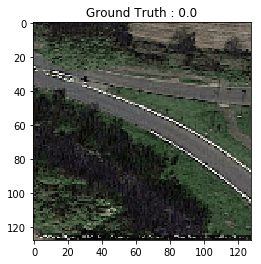

In [150]:
plt.imshow(images[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(labels[0]))

In [155]:
grid_squares_to_sort = list(df.index)

In [157]:
sorted(grid_squares_to_sort, key=lambda item: (int(item.partition(' ')[0])
                               if item[0].isdigit() else float('inf'), item))

ValueError: invalid literal for int() with base 10: '51.338,-0.4155'

In [4]:
def process_structured_data(df, train, test):
    # initialize the column names of the continuous and categorical data
    continuous = ["population_per_hectare", "bicycle_aadf", "motor_vehicle_aadf"]
    categorical = ['grid_square', 'safe']
 
    # performing min-max scaling each continuous feature column to the range [0, 1]
    cs = MinMaxScaler()
    trainContinuous = cs.fit_transform(train[continuous])
    testContinuous = cs.transform(test[continuous])

    trainCategorical = train[categorical]
    testCategorical = test[categorical]

    # construct our training and testing data points by concatenating the categorical features with the continuous features
    trainX = np.hstack([trainCategorical, trainContinuous])
    testX = np.hstack([testCategorical, testContinuous])
 
    # return the concatenated training and testing data
    return (trainX, testX)

In [45]:
def load_images(df, inputPath, output_size=64):
    # initialize our images array (i.e., the house images themselves)
    images = []
    image = np.zeros((64, 64, 3), dtype="uint8")
 
    # loop over the indexes of the houses
    for grid_square in df.index.values:
        # find the image for each row in the dataframe
        basePath = os.path.sep.join([inputPath, grid_square])
        image = cv2.imread(basePath)
#        image = cv2.resize(image, (output_size, output_size))
        images.append(image)

    # return our set of images
    return np.array(images)

In [6]:
def create_mlp(dim, final=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))
 
    # check to see if a final sigmoid layer should be added
    if final:
        model.add(Dense(1, activation="sigmoid"))
 
    # return our model
    return model

In [8]:
def create_cnn(width, height, depth, filters=(16, 32, 64), final=False):
    # initialize the input shape and channel dimension, assuming TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
 
    # define the model input
    inputs = Input(shape=inputShape)
 
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input appropriately
        if i == 0:
            x = inputs
 
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        
    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)
 
    # apply another FC layer, this one to match the number of nodes coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)
 
    # check to see if a final sigmoid layer should be added
    if final:
        x = Dense(1, activation="sigmoid")(x)
 
    # construct the CNN
    model = Model(inputs, x)
 
    # return the CNN
    return model        

In [17]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data/modelling", type=str, required=True,
    help="path to input dataset of images")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -d DATA/MODELLING
ipykernel_launcher.py: error: the following arguments are required: -d/--data/modelling


SystemExit: 2